In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression

from useful_functions.plotter import plot

idx = pd.IndexSlice

In [34]:
populations = pd.read_csv('../data/US_States/TrackTheRecovery/GeoIDs - State.csv', index_col='statefips')
case_data = pd.read_csv('../DL/data/states_unstacked.csv')
case_data = case_data[case_data['date'] <= '2021-02-25']
case_data = case_data.rename(columns={'Unnamed: 0': "statefips"})
case_data = case_data.sort_values(['date','statefips'])
case_data = case_data.reset_index(drop=True).set_index(['statefips','date']) # Let's see how this works
iso_index = pd.read_csv('../data/US_States/cleaned_data/mobility_pca_only.csv')
iso_index = iso_index.sort_values(['Date', 'statefips'])

case_data.index = case_data.index.set_levels([case_data.index.levels[0], pd.to_datetime(case_data.index.levels[1])])

state_ids = populations.index.values
dates = iso_index['Date'].unique()
dates.sort()

In [47]:
case_data['cumulativeDeaths'] = case_data.groupby(['statefips'])['deathIncrease'].cumsum(axis=0)
case_data['cumulativeHospitalized'] = case_data.groupby(['statefips'])['hospitalizedIncrease'].cumsum(axis=0)

# can probably do this better, because it adds an additional statefips multiindex level that I then have to remove
# this is a rolling sum of the 21 days prior to the date of interest
df = case_data.groupby('statefips')['positiveIncrease'].shift(1).groupby('statefips').rolling(21).sum()
case_data['rolling21DayPosLag1'] = df.droplevel(level=0)

# rolling 7-day positive increase
df = case_data.groupby('statefips')['positiveIncrease'].rolling(7).sum()
case_data['rolling7DayPos'] = df.droplevel(level=0)

df = case_data.groupby('statefips')['totalTestsPeopleViralIncrease'].rolling(7).sum() / populations['state_pop2019']
case_data['rolling7DayTestsPerCapita'] = df.droplevel(level=0)

# rolling 21-day positive increase
df = case_data.groupby('statefips')['positiveIncrease'].rolling(21).sum()
case_data['rolling21DayPos'] = df.droplevel(level=0)

df = case_data.groupby('statefips')['totalTestsPeopleViralIncrease'].rolling(21).sum() / populations['state_pop2019']
case_data['rolling21DayTestsPerCapita'] = df.droplevel(level=0)


case_data['newPositiveFraction'] = case_data['rolling7DayPos'] / case_data['rolling21DayPosLag1']

case_data['newDeathsIn14Days'] = case_data.groupby('statefips')['deathIncrease'].shift(-14)
df = case_data.groupby('statefips')['deathIncrease'].shift(-21).groupby('statefips').rolling(7).sum()
case_data['newDeathsIn14To21Days'] = df.droplevel(level=0)

case_data['rolling7DayTestsPerCapitaTimesPositives'] = case_data['rolling7DayTestsPerCapita']*case_data['rolling7DayPos']

In [48]:
median_testing_per_cap = case_data.loc[:,'rolling7DayTestsPerCapita'].max()
print(median_testing_per_cap)

0.15739023397271312


In [49]:
X = case_data.sort_index().loc[idx[:,'2020-03-01':'2021-02-01'], ['newDeathsIn14To21Days', 'rolling7DayTestsPerCapita']].values
Y = case_data.sort_index().loc[idx[:,'2020-03-01':'2021-02-01'], 'rolling7DayPos'].values.reshape(-1, 1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
print(linear_regressor.score(X,Y), linear_regressor.coef_, linear_regressor.intercept_)

0.6101222170583016 [[4.40681131e+01 4.83702832e+04]] [1515.87254698]


In [50]:
case_data['rolling7DayPosCorrected'] = linear_regressor.coef_[0][0]*case_data['newDeathsIn14To21Days'] + linear_regressor.coef_[0][1]*median_testing_per_cap + linear_regressor.intercept_

In [ ]:
 # Deaths14daysfromnow ~ Cases-in-the-last7 + Cases-in-the-last7 * Testing-per-capita-last-7 + Cases-in-the-last21 + Cases-in-the-last21*Testing-per-capita-last21

(0.0, 1.0)

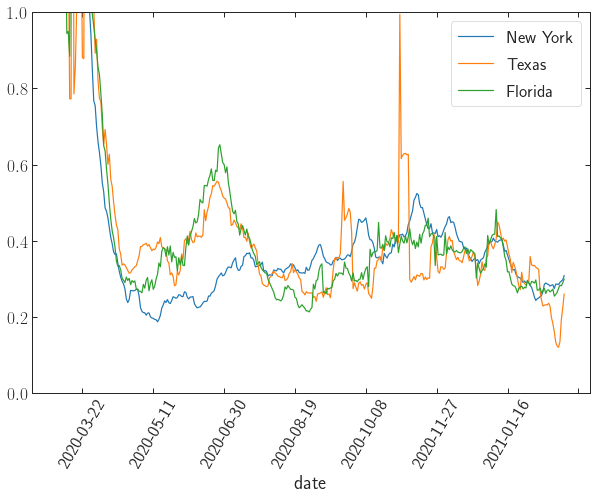

In [178]:
fig, ax = plot(figsize=(10,7))

for i,state in enumerate([36,48,12]):
    case_data.loc[state,:].plot(y='newPositiveFraction', ax=ax, label=populations.loc[state,'statename'])
    
plt.xticks(rotation = 60)
#plt.legend([],[])
plt.ylim(0,1)

(0.0, 1.0)

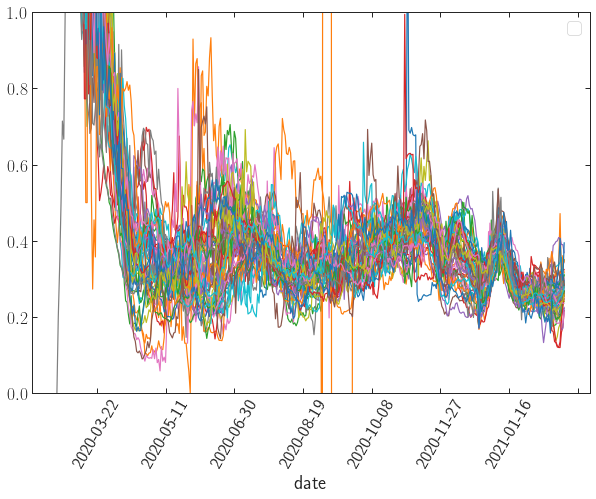

In [179]:
fig, ax = plot(figsize=(10,7))

for i,state in enumerate(state_ids):
    case_data.loc[state,:].plot(y='newPositiveFraction', ax=ax)
    
plt.xticks(rotation = 60)
plt.legend([],[])
plt.ylim(0,1)

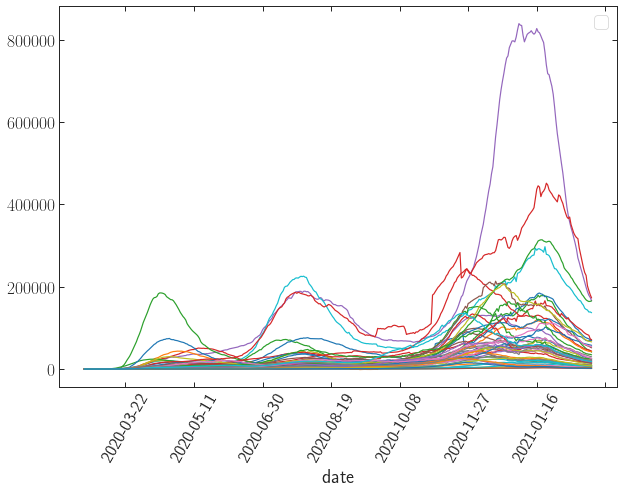

In [123]:
fig, ax = plot(figsize=(10,7))

for i,state in enumerate(state_ids):
    case_data.loc[state,:].plot(y='rolling21DayPosLag1', ax=ax)
    
plt.xticks(rotation = 60)
plt.legend([],[])

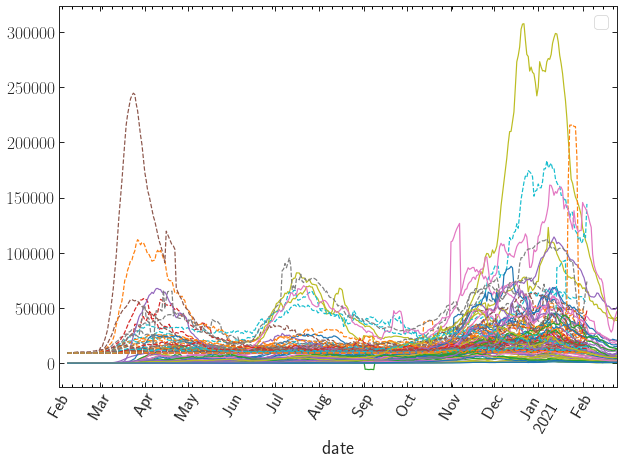

In [54]:
fig, ax = plot(figsize=(10,7))

for i,state in enumerate(state_ids):
    case_data.loc[state,:].plot(y='rolling7DayPos', ax=ax)
    case_data.loc[state,:].plot(y='rolling7DayPosCorrected', ax=ax, linestyle='dashed')
    
plt.xticks(rotation = 60)
plt.legend([],[])

(array([18293, 18322, 18353, 18383, 18414, 18444, 18475, 18506, 18536,
        18567, 18597, 18628, 18659, 18683]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

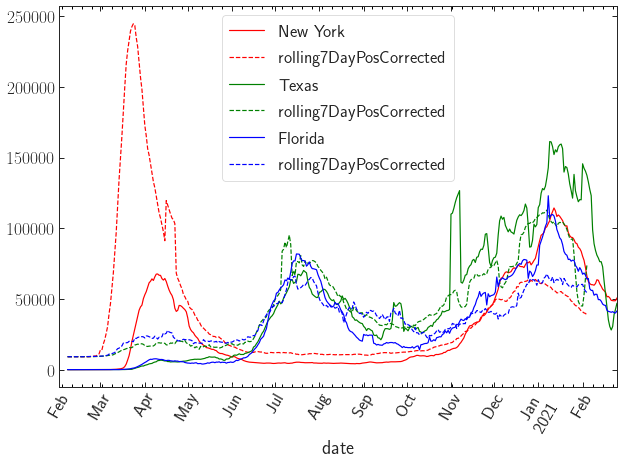

In [59]:
fig, ax = plot(figsize=(10,7))

cols = ['r','g','b']

for i,state in enumerate([36,48,12]):
    case_data.loc[state,:].plot(y='rolling7DayPos', ax=ax, label=populations.loc[state,'statename'],color=cols[i])
    case_data.loc[state,:].plot(y='rolling7DayPosCorrected', ax=ax, linestyle='dashed',color=cols[i])
    
plt.xticks(rotation = 60)
#plt.legend([],[])


[]

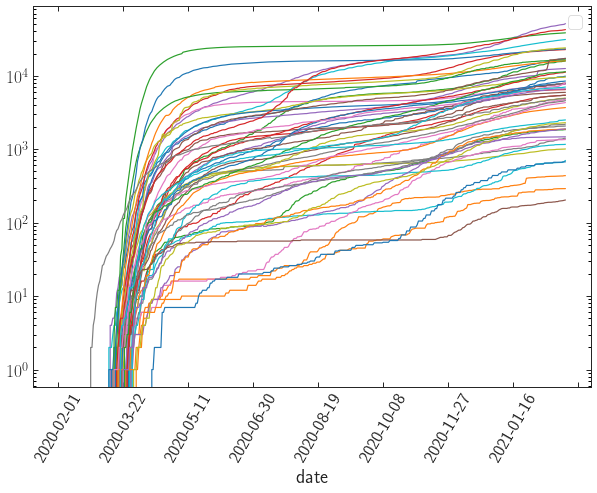

In [94]:
fig, ax = plot(figsize=(10,7))

for i,state in enumerate(state_ids):
    case_data.loc[state,:].plot(y='cumulativeDeaths', ax=ax)
    
plt.xticks(rotation = 60)
plt.legend([],[])
ax.semilogy()

In [ ]:
# Let's compute R(t), the fractional growth in a given day relative to the 21-day prior cumulative sum
